In [52]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Estimación de Insumos en el INT

En este cuadernillo se quieren estimar la cantidad de insumos que necesitará el INT para 2035 considerando su tasa de aumento en cada uno de los diagnósticos más relevantes. Los insumos que se quieren calcular son:

- Camas
- Pabellones
- Procedimientos más importantes (Resonancias, TAC Variadas, Estudios Histopatológicos - Biopsias, etc...)


In [54]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

## Lectura de bases de datos


In [55]:
# Lectura de base DEIS
egresos_torax_deis = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax_deis = egresos_torax_deis[egresos_torax_deis["DIAG1"].isin(DIAGS_RELEVANTES)]
egresos_torax_deis = egresos_torax_deis.drop(
    columns=[
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
)
egresos_torax_deis = egresos_torax_deis.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_deis["dias_en_anio"] = egresos_torax_deis["ANO_EGRESO"].apply(
    build_features.days_in_year
)

# Lectura de base GRD
egresos_torax_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")
egresos_torax_grd = egresos_torax_grd.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_grd["dias_en_anio"] = egresos_torax_grd["ANO_EGRESO"].apply(
    build_features.days_in_year
)

## Estimación de Cantidad de Camas

Para estimar la cantidad de camas necesarias se utilizarán los días de estada necesarios para
cada uno de los diagnósticos. Además, se obtendrán los días para cada uno de los años analizados. La fórmula para calcular la cantidad de camas es:

$Cantidad De Camas = \frac{Dias Estada En Periodo}{Cantidad Dias Periodo}$

Por ejemplo:

Si un diangóstico X tiene 2450 Días de Estada en 1 año (no bisiesto), entonces se necesitan la siguiente cantidad de camas para suplir tal diagnóstico:

$Cantidad De Camas = \frac{2450}{365} = 6.7 Camas$


In [56]:
egresos_torax_deis["camas_necesarias"] = (
    egresos_torax_deis["dias_estada_totales"] / egresos_torax_deis["dias_en_anio"]
)
egresos_torax_grd["camas_necesarias"] = (
    egresos_torax_grd["dias_estada"] / egresos_torax_grd["dias_en_anio"]
)

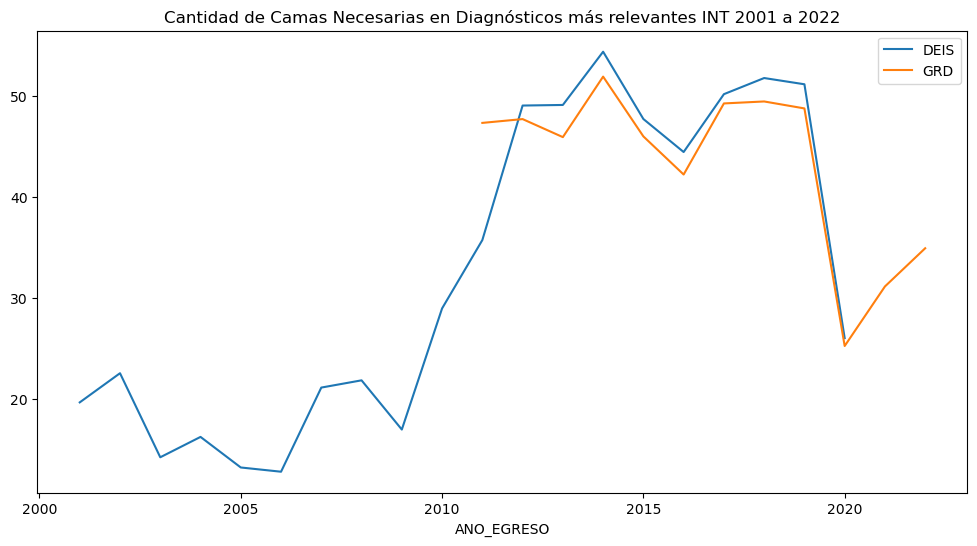

In [57]:
cantidad_camas_deis = egresos_torax_deis.groupby("ANO_EGRESO")["camas_necesarias"].sum()
cantidad_camas_grd = egresos_torax_grd.groupby("ANO_EGRESO")["camas_necesarias"].sum()

fig, axis = plt.subplots()
cantidad_camas_deis.plot(ax=axis, label="DEIS")
cantidad_camas_grd.plot(ax=axis, label="GRD")
plt.legend()
plt.title("Cantidad de Camas Necesarias en Diagnósticos más relevantes INT 2001 a 2022")
plt.show()

Una vez se tiene la necesidad real del INT, es posible calcular la cantidad de camas necesarias con
un aumento en la necesidad. Asumiendo un aumento del 79% de la demanda de los diagnósticos más relevantes en el INT (según modelo de pronóstico), la demanda sería:


In [58]:
AUMENTO_DEMANDA = 1.79

In [59]:
cantidad_camas_deis = cantidad_camas_deis.to_frame()
cantidad_camas_deis["aumento_camas"] = cantidad_camas_deis["camas_necesarias"] * AUMENTO_DEMANDA

cantidad_camas_grd = cantidad_camas_grd.to_frame()
cantidad_camas_grd["aumento_camas"] = cantidad_camas_grd["camas_necesarias"] * AUMENTO_DEMANDA

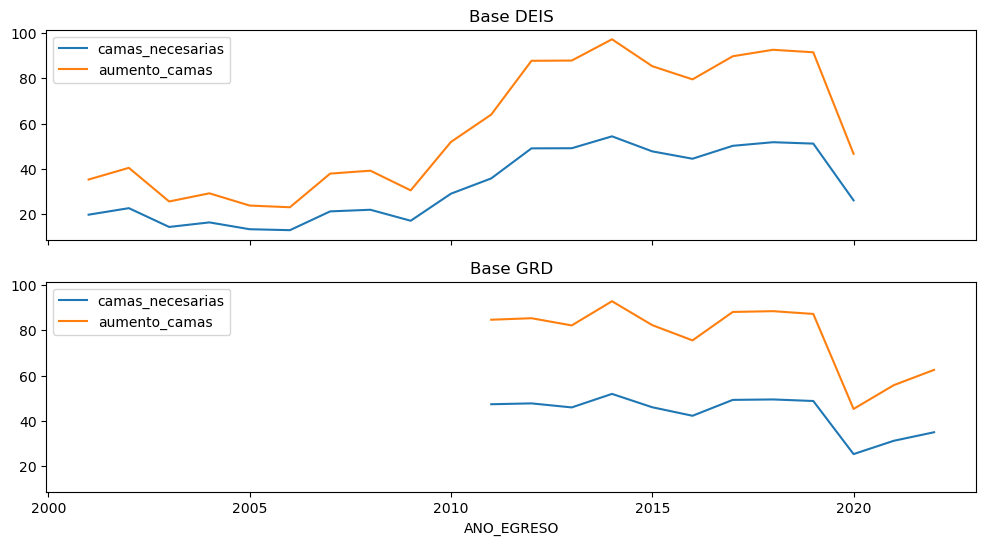

In [60]:
fig, axis = plt.subplots(2, 1, sharey=True, sharex=True)
cantidad_camas_deis.plot(ax=axis[0])
cantidad_camas_grd.plot(ax=axis[1])

axis[0].title.set_text("Base DEIS")
axis[1].title.set_text("Base GRD")
plt.show()

In [61]:
display(cantidad_camas_deis)
display(cantidad_camas_grd)

,camas_necesarias,aumento_camas
ANO_EGRESO,,
2001,19.687671,35.240932
2002,22.569863,40.400055
2003,14.263014,25.530795
2004,16.275956,29.133962
2005,13.254795,23.726082
2006,12.835616,22.975753
2007,21.150685,37.859726
2008,21.866120,39.140355
2009,17.002740,30.434904


,camas_necesarias,aumento_camas
ANO_EGRESO,,
2011,47.304110,84.674356
2012,47.680328,85.347787
2013,45.898630,82.158548
2014,51.876712,92.859315
2015,45.969863,82.286055
2016,42.202186,75.541913
2017,49.227397,88.117041
2018,49.421918,88.465233
2019,48.734247,87.234301


Los resultados indican que el año 2014 fue donde hubo una mayor ocupación de camas por los diagnósticos. Al observar el aumento, se puede ver que aumenta de 54 a 93 camas (aumento de **39 camas**)


## Estimación de Aumento de Procedimientos

Para estimar el aumento de procedimientos, se utilizará la canasta de procedimientos extraída desde
GRD FONASA 2019 a 2021. El análisis consistirá en aumentar proporcionalmente cada una de las
prestaciones necesarias para cada uno de los diagnósticos.


In [62]:
COLUMNAS_A_ELIMINAR = [
    "Código_x",
    "Categoría_x",
    "Sección_x",
    "Capítulo_x",
    "Versión",
    "Código_y",
    "Categoría_y",
    "Sección_y",
    "Capítulo_y",
]

In [63]:
# Lee base de Procedimientos GRD 2019 a 2021
procedimientos_grd = pd.read_excel("../data/processed/canasta_procedimientos_hospitalizados.xlsx")
procedimientos_grd["DIAGNOSTICO1"] = (
    procedimientos_grd["DIAGNOSTICO1"].str.replace(".", "", regex=False).str.ljust(4, "X")
)
procedimientos_grd = procedimientos_grd[procedimientos_grd["DIAGNOSTICO1"].isin(DIAGS_RELEVANTES)]
procedimientos_grd = procedimientos_grd.drop(columns=COLUMNAS_A_ELIMINAR)

Ahora, lo único que debe aumentar en cada uno de los procedimientos es la cantidad de procedimientos
y la cantidad de pacientes distintos. Esto, ya que la proporción de procedimientos_por_pacientes
se debe mantener.


In [64]:
COLUMNAS_A_AUMENTAR_GRD = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

In [65]:
# Aumenta proporcionalmente los procedimientos
aumento_procedimientos_grd = procedimientos_grd.copy()
aumento_procedimientos_grd[
    ["cantidad_procedimientos_aumentados", "cantidad_pacientes_distintos_aumentados"]
] = (aumento_procedimientos_grd[COLUMNAS_A_AUMENTAR_GRD] * AUMENTO_DEMANDA)

Ahora, existen procedimientos de alto interés que se quiere saber su aumento. Estos procedimientos
son:

- Tomografías
- Resonancias Magnéticas
- Biopsias
- Otros...

Por lo tanto, es necesario hacer un resumen de su aumento.


In [66]:
PROCEDIMIENTOS_DE_INTERES = ["TOMOGRAFIA", "RESONANCIA", "BIOPSIA", "LOBECTOMIA", "BRONCOSCOPIA"]
resultados_aumento = {}

for procedimiento in PROCEDIMIENTOS_DE_INTERES:
    resumen_procedimiento = build_features.obtener_aumento_de_procedimiento_especifico(
        aumento_procedimientos_grd, procedimiento
    )
    print(f"> {procedimiento}:")
    display(resumen_procedimiento)

    resultados_aumento[procedimiento] = resumen_procedimiento

> TOMOGRAFIA:


,cantidad_procedimientos,cantidad_procedimientos_aumentados
ANIO_EGRESO,,
2019,965,1727.35
2020,491,878.89
2021,663,1186.77


> RESONANCIA:


,cantidad_procedimientos,cantidad_procedimientos_aumentados
ANIO_EGRESO,,
2019,11,19.69
2020,8,14.32
2021,3,5.37


> BIOPSIA:


,cantidad_procedimientos,cantidad_procedimientos_aumentados
ANIO_EGRESO,,
2019,759,1358.61
2020,210,375.90
2021,296,529.84


> LOBECTOMIA:


,cantidad_procedimientos,cantidad_procedimientos_aumentados
ANIO_EGRESO,,
2019,64,114.56
2020,31,55.49
2021,59,105.61


> BRONCOSCOPIA:


,cantidad_procedimientos,cantidad_procedimientos_aumentados
ANIO_EGRESO,,
2019,100,179.00
2020,68,121.72
2021,132,236.28


## Estimación de Pabellones necesarios

Para este análisis se utilizarán la base de datos DEIS y la base de datos de Pabellón. Con la primera base se identificarán los egresos que tuvieron una intervención quirúrgica. Con la segunda base se obtendrá el tiempo promedio utilizado para realizar tales intervenciones.

Una vez realizado el cruce, se obtendrán las horas empleadas en total para cada uno de los diagnósticos por año. Finalmente, se obtendrá la cantidad utilizada de un pabellón.


In [67]:
# Lee resumen de Intervenciones quirúrgicas de Egresos DEIS entre 2001 a 2020.
df_int_q = pd.read_csv("../data/processed/resumen_intervenciones_quir_torax.csv")

# Lee resumen de duraciones de las Intervenciones quirúrgicas de pabellón INT
df_duraciones = pd.read_excel("../data/processed/resumen_duraciones_totales.xlsx")
df_duraciones["mean"] = pd.to_timedelta(df_duraciones["mean"], unit="h").round("s")

In [68]:
# Une la base de DEIS con la de Pabellon en el codigo MAI
union = df_int_q.merge(
    df_duraciones, how="left", left_on="CODIGO_INTERV_Q_PPAL", right_on="codigo_i"
)

# Calcula la cantidad de horas invertidas en cada tipo de operacion
union["duracion_total_por_int_q"] = union["count_x"] * union["mean"]

In [69]:
display(union.tail(4))

,ANO_EGRESO,DIAG1,CODIGO_INTERV_Q_PPAL,GLOSA_INTERV_Q_PPAL,count_x,codigo_i,GLOSA PRESTACION,count_y,mean,std,min,25%,50%,75%,max,duracion_total_por_int_q
6232,2020,Z450,1703153,Implantación de marcapaso c/electrod. intraven...,1,1703153.0,Implantación de marcapaso c/electrod. intraven...,195.0,0 days 01:39:45,0.905103,0.500000,1.083333,1.333333,2.000000,6.416667,0 days 01:39:45
6233,2020,Z470,1704009,"Toracotomía exploradora, c/s biopsia, c/s debr...",1,1704009.0,"Toracotomía exploradora, c/s biopsia, c/s debr...",448.0,0 days 02:57:35,1.591266,0.750000,1.750000,2.750000,3.750000,13.250000,0 days 02:57:35
6234,2020,Z470,1704004,"Reparación pectum excavatum o carinatum, (proc...",1,1704004.0,"Reparación pectum excavatum o carinatum, (proc...",103.0,0 days 02:33:09,0.997341,0.750000,1.833333,2.500000,3.083333,6.333333,0 days 02:33:09
6235,2020,Z470,2106003,"Retiro de tornillos, clavos, agujas de osteosí...",1,2106003.0,"Retiro de tornillos, clavos, agujas de osteosí...",63.0,0 days 01:46:26,0.975670,0.416667,1.083333,1.666667,2.083333,5.416667,0 days 01:46:26


Por lo tanto, se pueden ver todos los tipos de intervenciones quirúrgicas realizada para cada tipo de diagnóstico para cada año. Además, se puede ver el tiempo invertido total para cada combinación de estas 3 variables.

A modo de control, se observarán las intervenciones quirúrgicas que quedaron sin unirse a la base de pabellón. Por otro lado se sabe que la base de pabellón es desde 2015 hasta 2022. Por lo tanto, es esperable que la mayor cantidad de operaciones ausentes en pabellón existan previo a este periodo.

In [70]:
# Se quiere identificar cuantas operaciones faltan en pabellon por anio
display(union[union["codigo_i"].isna()].groupby(["ANO_EGRESO"])["count_x"].sum())

ANO_EGRESO
2004     9
2005    15
2006     7
2007    30
2008    25
2009    60
2010    32
2011    39
2012    18
2013     8
2014    10
2015     6
2016     4
2017     1
2018     1
Name: count_x, dtype: int64

Los resultados indican que la mayor cantidad de cirugias faltantes en la base de pabellón son previas a 2015. Desde 2015 solamente faltan 12 operaciones en la base de pabellón. Esto indicaría que faltarían los tiempos de operación para estas intervenciones quirúrgicas.

Además, se quieren identificar los códigos que están en DEIS y Pabellón que carecen de un arancel MAI. Esto, para identificar si es necesario recodificar estos códigos a otro que ya exista en la base de pabellón.

In [71]:
# Selecciona las operaciones sin una glosa de arancel MAI pero que si se unieron a la base de
# pabellon. Luego cuenta la cantidad de operaciones por codigo.
display(
    union[union["GLOSA PRESTACION"].isna() & union["codigo_i"].notna()]
    .groupby(["CODIGO_INTERV_Q_PPAL", "GLOSA_INTERV_Q_PPAL"])["count_y"]
    .sum()
)

CODIGO_INTERV_Q_PPAL  GLOSA_INTERV_Q_PPAL                                                           
170306                Código no existe actualmente                                                          1.0
402032                Instalaciï¿½n de catï¿½ter o sonda intracardï¿½aca, control por radiï¿½logo        3512.0
                      Instalación de catéter o sonda intracardíaca, control por radiólogo               13170.0
1602010               Código no existe actualmente                                                          2.0
1602016               Código no existe actualmente                                                          1.0
1703004               Fístula arteriovenosa derivación externa                                              6.0
1703041               Disecciï¿½n y extirpaciï¿½n  ganglionar regional (proc. aut.): mediastï¿½nicos       57.0
                      Disección y extirpación  ganglionar regional (proc. aut.): mediastínicos           1026.0
   

## Calculo de Tiempo de Pabellón utilizado para cada uno de los diagnósticos

Ahora que se ha hecho el control de calidad, y se sabe que solamente faltan 12 operaciones en en la base de pabellón, es posible calcular cuánto utiliza en promedio cada uno de los diagnósticos en pabellón.

In [72]:
pabellon_por_diag = (
    union.groupby(["ANO_EGRESO", "DIAG1"])["duracion_total_por_int_q"].sum().reset_index()
)

In [73]:
display(pabellon_por_diag)

,ANO_EGRESO,DIAG1,duracion_total_por_int_q
0,2004,A162,0 days 02:57:35
1,2004,B449,0 days 06:26:09
2,2004,B59X,0 days 02:03:24
3,2004,B673,0 days 04:11:24
4,2004,B679,2 days 07:26:33
...,...,...,...
2682,2020,T862,0 days 01:07:07
2683,2020,U071,1 days 13:01:33
2684,2020,Z430,0 days 01:07:07
2685,2020,Z450,0 days 12:27:45


Por lo tanto, podemos ver cuánto utilizó cada uno de los diagnósticos el pabellón. Ahora podemos aislar solamente los diagnósticos de interés e identificar la necesidad de pabellón para estos diags.


In [74]:
# Calcula el tiempo utilizado por todos los diags
tiempo_pabellon_total = (
    pabellon_por_diag.groupby("ANO_EGRESO")["duracion_total_por_int_q"].sum().dt.total_seconds()
) / 3600

# Calcula el tiempo utilizado por los diags relevantes
tiempo_pabellon_relevantes = pabellon_por_diag[pabellon_por_diag["DIAG1"].isin(DIAGS_RELEVANTES)]
tiempo_pabellon_relevantes = (
    tiempo_pabellon_relevantes.groupby("ANO_EGRESO")["duracion_total_por_int_q"]
    .sum()
    .dt.total_seconds()
) / 3600

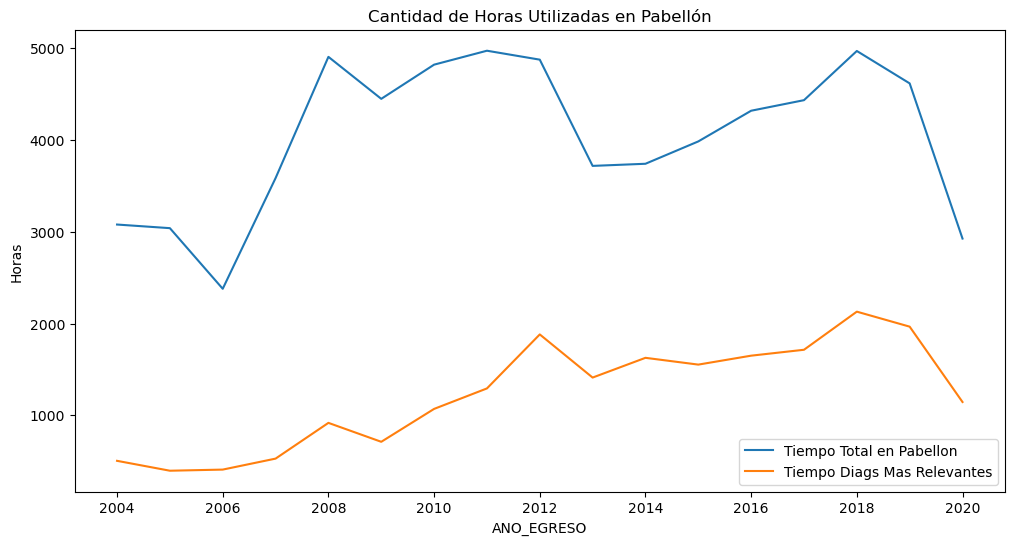

In [75]:
fig, axis = plt.subplots()
tiempo_pabellon_total.plot(ax=axis, label="Tiempo Total en Pabellon")
tiempo_pabellon_relevantes.plot(ax=axis, label="Tiempo Diags Mas Relevantes")
plt.title("Cantidad de Horas Utilizadas en Pabellón")
plt.ylabel("Horas")
plt.legend()
plt.show()

In [76]:
display(tiempo_pabellon_relevantes.to_frame().style.highlight_max(color="pink"))

,duracion_total_por_int_q
ANO_EGRESO,
2004,504.729722
2005,396.884722
2006,409.167778
2007,528.861944
2008,918.459444
2009,712.061389
2010,1070.591389
2011,1293.738611
2012,1882.281667


Para calcular la cantidad de pabellones necesarios se realizará lo siguiente:

- Se asumirá que 1 pabellón es utilizable por 9 horas al día
- Se asumirá que 1 pabellón es utilizable todos los días de un año

Teniendo en cuenta esto, la capacidad máxima de 1 pabellón al año (no bisiesto) es:

$CapacidadMaximaPabellon = 365 dias * 9 horas/dia = 3285 HorasAlAño$

In [93]:
CAPACIDAD_MAXIMA_PABELLON_ANUAL = 9 * 365.4

# Calcula necesidad actual para todos los diagnosticos
pabellones_necesarios_totales = tiempo_pabellon_total / CAPACIDAD_MAXIMA_PABELLON_ANUAL

# Calcula necesidad actual de diags relevantes
pabellones_necesarios_por_dia = tiempo_pabellon_relevantes / CAPACIDAD_MAXIMA_PABELLON_ANUAL

# Calcula necesidad en el futuro para diags relevantes
pabellones_necesarios_por_dia_aumentados = pabellones_necesarios_por_dia * AUMENTO_DEMANDA

print("Utilización actual de pabellones INT")
display(pabellones_necesarios_totales.to_frame().style.highlight_max(color="pink"))
print("Utilización de diagnósticos más relevantes de pabellón INT")
display(pabellones_necesarios_por_dia.to_frame().style.highlight_max(color="pink"))
print("Porcentaje de utilización de pabellón diags más relevantes INT")
display(
    ((pabellones_necesarios_por_dia / pabellones_necesarios_totales) * 100)
    .to_frame()
    .style.highlight_max(color="pink")
)

print("Utilización de diagnósticos más relevantes Aumentados de pabellón INT")
display(pabellones_necesarios_por_dia_aumentados.to_frame().style.highlight_max(color="pink"))

Utilización actual de pabellones INT


,duracion_total_por_int_q
ANO_EGRESO,
2004,0.936548
2005,0.924544
2006,0.723641
2007,1.090453
2008,1.492271
2009,1.353103
2010,1.466405
2011,1.512574
2012,1.482973


Utilización de diagnósticos más relevantes de pabellón INT


,duracion_total_por_int_q
ANO_EGRESO,
2004,0.153479
2005,0.120685
2006,0.124420
2007,0.160817
2008,0.279286
2009,0.216524
2010,0.325546
2011,0.393401
2012,0.572366


Porcentaje de utilización de pabellón diags más relevantes INT


,duracion_total_por_int_q
ANO_EGRESO,
2004,16.387692
2005,13.053462
2006,17.193607
2007,14.747701
2008,18.715487
2009,16.002043
2010,22.200299
2011,26.008705
2012,38.595817


Utilización de diagnósticos más relevantes Aumentados de pabellón INT


,duracion_total_por_int_q
ANO_EGRESO,
2004,0.274727
2005,0.216026
2006,0.222712
2007,0.287862
2008,0.499922
2009,0.387578
2010,0.582728
2011,0.704188
2012,1.024535


Algo interesante a notar es que la necesidad máxima de pabellones en el INT contando todos los diagnósticos fue en 2011. En tal año se utilizaron 1.51 pabellones los 365 días del año por 9 horas.

- Al investigar la necesidad de los diagnósticos más relevantes, se observa que estos utilizaron 

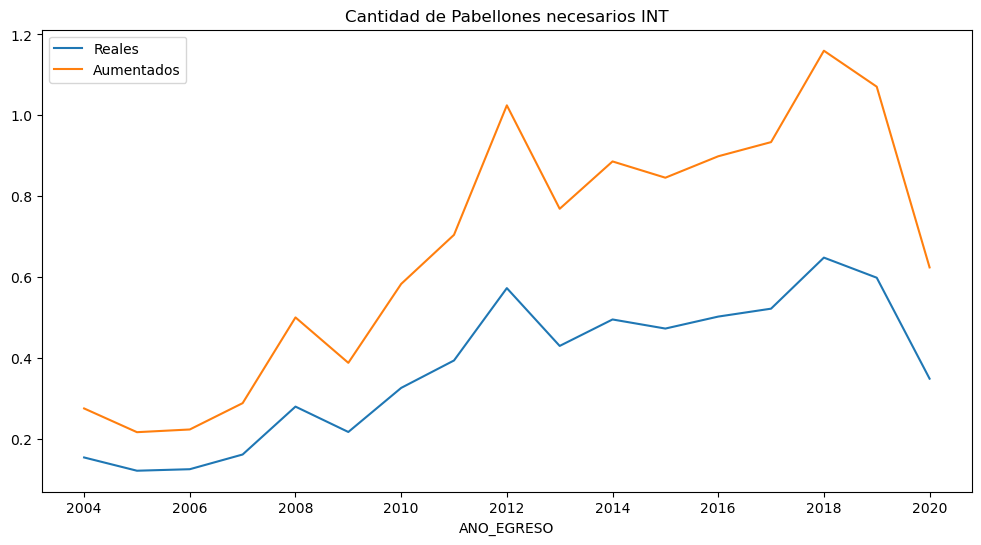

In [94]:
fig, axis = plt.subplots()
pabellones_necesarios_por_dia.plot(ax=axis, label="Reales")
pabellones_necesarios_por_dia_aumentados.plot(ax=axis, label="Aumentados")
plt.title("Cantidad de Pabellones necesarios INT")
plt.legend()
plt.show()

Los resultados indican lo siguiente:

- El 2018 fue el año donde hubo la mayor ocupación de pabellones
- Al ver la demanada con los egresos aumentados, es necesario tener por lo menos **1.2** pabellones
utilizados los 365 días de la semana por 9 horas para los diagnósticos más relevantes.